# IMPORTS

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier, DMatrix, train as xgb_train
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# Data set Preparation

In [2]:
# Check for missing values
awards_players = pd.read_csv('awards_players.csv')
coaches = pd.read_csv('coaches.csv')
players = pd.read_csv('players.csv')
players_teams = pd.read_csv('players_teams.csv')
series_post = pd.read_csv('series_post.csv')
teams = pd.read_csv('teams.csv')
teams_post = pd.read_csv('teams_post.csv')

## Players

In [3]:
# Drop unnecessary columns only after all calculations are done
players.drop(['firstseason', 'lastseason','deathDate','collegeOther'], axis=1, inplace=True)


In [4]:
players.head()

,bioID,pos,height,weight,college,birthDate
0,abrahta01w,C,74.0,190,George Washington,1975-09-27
1,abrossv01w,F,74.0,169,Connecticut,1980-07-09
2,adairje01w,C,76.0,197,George Washington,1986-12-19
3,adamsda01w,F-C,73.0,239,Texas A&M,1989-02-19
4,adamsjo01w,C,75.0,180,New Mexico,1981-05-24


## Teams

In [5]:
# Assuming the uploaded CSV is already loaded into a dataframe named `teams`
# 1. Win Ratios
teams['win_ratio'] = teams['won'] / teams['GP']
teams.drop(['won'], axis=1, inplace=True)

teams['home_win_ratio'] = teams['homeW'] / (teams['homeW'] + teams['homeL'])
teams.drop(['homeW', 'homeL'], axis=1, inplace=True)

teams['away_win_ratio'] = teams['awayW'] / (teams['awayW'] + teams['awayL'])
teams.drop(['awayW', 'awayL'], axis=1, inplace=True)

teams['conf_win_ratio'] = teams['confW'] / (teams['confW'] + teams['confL'])
teams.drop(['confW', 'confL'], axis=1, inplace=True)

# 2. Scoring Efficiency
teams['off_efficiency'] = teams['o_pts'] / (teams['o_fga'] + teams['o_fta'])
teams.drop(['o_pts', 'o_fga', 'o_fta'], axis=1, inplace=True)

teams['def_efficiency'] = teams['d_pts'] / (teams['d_fga'] + teams['d_fta'])
teams.drop(['d_pts', 'd_fga', 'd_fta'], axis=1, inplace=True)

# 3. Rebounding Metrics
teams['off_reb_percentage'] = teams['o_oreb'] / (teams['o_oreb'] + teams['d_dreb'])
teams.drop(['o_oreb', 'd_dreb'], axis=1, inplace=True)

teams['def_reb_percentage'] = teams['o_dreb'] / (teams['o_dreb'] + teams['d_oreb'])
teams.drop(['o_dreb', 'd_oreb'], axis=1, inplace=True)

# 4. Turnover Ratio
teams['to_ratio'] = teams['o_to'] / teams['GP']

# Assuming the dataframe is named `teams`

# 1. Scoring Contribution
teams['fgm_contribution'] = teams['o_fgm'] * 2 + teams['o_3pm'] * 3
teams['ftm_contribution'] = teams['o_ftm']  # Free throws worth 1 point each
teams['three_point_ratio'] = teams['o_3pm'] / teams['o_3pa']

# Drop the columns used above
teams.drop(['o_fgm', 'o_3pm', 'o_ftm', 'o_3pa'], axis=1, inplace=True)

# 3. Assist-to-Turnover Ratios
teams['off_ast_to_ratio'] = teams['o_asts'] / teams['o_to']
teams['def_ast_to_ratio'] = teams['d_asts'] / teams['d_to']

# Drop assist and turnover columns
teams.drop(['o_asts', 'd_asts', 'o_to', 'd_to'], axis=1, inplace=True)

# 4. Steal and Block Ratios
teams['off_steal_ratio'] = teams['o_stl'] / teams['GP']
teams['off_block_ratio'] = teams['o_blk'] / teams['GP']
teams['def_steal_ratio'] = teams['d_stl'] / teams['GP']
teams['def_block_ratio'] = teams['d_blk'] / teams['GP']

# Drop the corresponding columns
teams.drop(['o_stl', 'o_blk', 'd_stl', 'd_blk'], axis=1, inplace=True)

# 5. Efficiency per Minute
teams['efficiency_per_min'] = (teams['win_ratio'] + teams['off_efficiency'] - teams['def_efficiency']) / teams['min']

# Drop the `min` column as it's been used
teams.drop(['min'], axis=1, inplace=True)

# 6. Points allowed vs. Points scored
teams['points_diff'] = (teams['win_ratio'] * teams['GP'] * teams['off_efficiency']) - (teams['def_efficiency'] * teams['GP'] * teams['win_ratio'])

# Drop any other residual columns
# DivID, seeded,'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB'  are always nan or 0
# arena and name are irrelevant
# lgID is alaway the same WNBA
# 'firstRound','semis', 'finals' to prevent future data leakage
teams.drop(['tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB','d_fgm', 'd_ftm', 'd_3pm', 'd_3pa', 'o_reb', 'd_reb', 'o_pf', 'd_pf', 'lost','divID','arena','lgID','name','seeded','firstRound','semis', 'finals'], axis=1, inplace=True)


In [6]:
teams.head()

,year,tmID,franchID,confID,rank,playoff,GP,attend,win_ratio,home_win_ratio,away_win_ratio,conf_win_ratio,off_efficiency,def_efficiency,off_reb_percentage,def_reb_percentage,to_ratio,fgm_contribution,ftm_contribution,three_point_ratio,off_ast_to_ratio,def_ast_to_ratio,off_steal_ratio,off_block_ratio,def_steal_ratio,def_block_ratio,efficiency_per_min,points_diff
0,9,ATL,ATL,EA,7,N,34,141379,0.117647,0.058824,0.176471,0.100000,0.849480,0.907629,0.282392,0.647627,17.441176,2396,542,0.337793,0.829680,1.219251,8.382353,4.176471,9.117647,3.941176,0.000009,-0.232595
1,10,ATL,ATL,EA,2,Y,34,120737,0.529412,0.705882,0.352941,0.454545,0.898838,0.882334,0.329796,0.707781,17.352941,2520,569,0.304813,0.927119,1.023295,9.676471,3.558824,10.205882,3.911765,0.000079,0.297057
2,1,CHA,CHA,EA,8,N,32,90963,0.250000,0.312500,0.187500,0.238095,0.881452,0.917989,0.314757,0.658996,15.500000,2017,431,0.339378,1.110887,1.399061,6.937500,2.812500,8.093750,3.843750,0.000033,-0.292302
3,2,CHA,CHA,EA,4,Y,32,105525,0.562500,0.687500,0.437500,0.714286,0.890381,0.834302,0.352740,0.650051,14.812500,1951,410,0.357477,0.985232,0.991051,6.781250,3.562500,8.031250,3.875000,0.000095,1.009421
4,3,CHA,CHA,EA,2,Y,32,106670,0.562500,0.687500,0.437500,0.571429,0.913575,0.886902,0.327549,0.688819,12.750000,2173,490,0.400380,1.215686,1.153302,7.531250,3.281250,6.500000,3.218750,0.000091,0.480113


In [7]:
# Use `teams_post` dataframe for augmentation
# 1. Win Ratio
teams_post['win_ratio_post'] = teams_post['W'] / (teams_post['W'] + teams_post['L'])

# 2. Total Games Played
teams_post['total_games_post'] = teams_post['W'] + teams_post['L']

# 3. Winning Margin
teams_post['win_margin_post'] = teams_post['W'] - teams_post['L']

# Drop the columns used for calculations
teams_post.drop(['W', 'L','lgID'], axis=1, inplace=True)
teams_post.fillna(0, inplace=True)

## player_teams

In [8]:
# Use `players_teams` dataframe for augmentation

# 1. Per-Game Metrics
players_teams['points_per_game'] = players_teams['points'] / players_teams['GP']
players_teams['rebounds_per_game'] = (players_teams['oRebounds'] + players_teams['dRebounds']) / players_teams['GP']
players_teams['assists_per_game'] = players_teams['assists'] / players_teams['GP']
players_teams['steals_per_game'] = players_teams['steals'] / players_teams['GP']
players_teams['blocks_per_game'] = players_teams['blocks'] / players_teams['GP']

# Drop columns used for the above calculations
players_teams.drop(['points', 'oRebounds', 'dRebounds', 'assists', 'steals', 'blocks'], axis=1, inplace=True)

# 2. Efficiency Ratios
players_teams['assist_to_turnover_ratio'] = players_teams['assists_per_game'] / players_teams['turnovers']
players_teams['points_per_minute'] = players_teams['points_per_game'] / players_teams['minutes']

# Drop the `turnovers` column
players_teams.drop(['turnovers'], axis=1, inplace=True)

# 3. Postseason Metrics (mirror regular season)
players_teams['post_points_per_game'] = players_teams['PostPoints'] / players_teams['PostGP']
players_teams['post_rebounds_per_game'] = (players_teams['PostoRebounds'] + players_teams['PostdRebounds']) / players_teams['PostGP']
players_teams['post_assists_per_game'] = players_teams['PostAssists'] / players_teams['PostGP']

# Drop the postseason columns used
players_teams.drop(['PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostAssists'], axis=1, inplace=True)

# 4. Player Impact Score
players_teams['player_impact_score'] = (players_teams['points_per_game'] + players_teams['rebounds_per_game'] +
                                        players_teams['assists_per_game'] + players_teams['steals_per_game'] * 2)

# 1. Shooting Efficiency Metrics
players_teams['fg_percentage'] = players_teams['fgMade'] / players_teams['fgAttempted']
players_teams['ft_percentage'] = players_teams['ftMade'] / players_teams['ftAttempted']
players_teams['three_point_percentage'] = players_teams['threeMade'] / players_teams['threeAttempted']

# Drop columns used above
players_teams.drop(['fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade'], axis=1, inplace=True)

# 2. Fouls and Discipline Metrics
# Use `GP` before dropping it
players_teams['foul_rate'] = players_teams['PF'] / players_teams['GP']
players_teams['disqualification_rate'] = players_teams['dq'] / players_teams['GP']

# Drop columns used above
players_teams.drop(['PF', 'dq'], axis=1, inplace=True)

# 3. Postseason Shooting Efficiency
players_teams['post_fg_percentage'] = players_teams['PostfgMade'] / players_teams['PostfgAttempted']
players_teams['post_ft_percentage'] = players_teams['PostftMade'] / players_teams['PostftAttempted']
players_teams['post_three_point_percentage'] = players_teams['PostthreeMade'] / players_teams['PostthreeAttempted']

# Drop postseason shooting columns used
players_teams.drop(['PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade',
                    'PostthreeAttempted', 'PostthreeMade'], axis=1, inplace=True)

# 4. Postseason Impact Metrics
# Use `PostGP` before dropping it
players_teams['post_rebounds_per_game'] = players_teams['PostRebounds'] / players_teams['PostGP']
players_teams['post_steals_per_game'] = players_teams['PostSteals'] / players_teams['PostGP']
players_teams['post_blocks_per_game'] = players_teams['PostBlocks'] / players_teams['PostGP']
players_teams['post_turnover_rate'] = players_teams['PostTurnovers'] / players_teams['PostGP']
players_teams['post_foul_rate'] = players_teams['PostPF'] / players_teams['PostGP']
players_teams['post_disqualification_rate'] = players_teams['PostDQ'] / players_teams['PostGP']

# Drop the GP columns only after they have been used
players_teams.drop(['PostGP', 'minutes', 'GP', 'GS', 'PostRebounds', 'PostSteals', 'PostBlocks',
                    'PostTurnovers', 'PostPF', 'PostDQ', 'PostGS', 'PostMinutes','lgID'], axis=1, inplace=True)

players_teams.fillna(0, inplace=True)

In [9]:
players_teams.head()

,playerID,year,stint,tmID,rebounds,points_per_game,rebounds_per_game,assists_per_game,steals_per_game,blocks_per_game,assist_to_turnover_ratio,points_per_minute,post_points_per_game,post_rebounds_per_game,post_assists_per_game,player_impact_score,fg_percentage,ft_percentage,three_point_percentage,foul_rate,disqualification_rate,post_fg_percentage,post_ft_percentage,post_three_point_percentage,post_steals_per_game,post_blocks_per_game,post_turnover_rate,post_foul_rate,post_disqualification_rate
0,abrossv01w,2,0,MIN,174,13.192308,6.692308,2.038462,1.615385,0.346154,0.023982,0.015594,0.000000,0.000000,0.000000,25.153846,0.389078,0.727273,0.250000,2.692308,0.076923,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,abrossv01w,3,0,MIN,146,11.629630,5.407407,2.222222,1.555556,0.370370,0.024155,0.014447,0.000000,0.000000,0.000000,22.370370,0.376582,0.482759,0.333333,2.703704,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,abrossv01w,4,0,MIN,141,10.600000,4.700000,2.733333,1.466667,0.366667,0.030370,0.013384,7.666667,1.666667,1.333333,20.966667,0.392982,0.704082,0.304878,2.633333,0.000000,0.272727,1.0,0.428571,1.333333,0.333333,2.666667,2.666667,0.0
3,abrossv01w,5,0,MIN,74,6.636364,3.363636,2.045455,1.363636,0.090909,0.047569,0.014364,10.000000,4.500000,1.500000,14.772727,0.352518,0.608696,0.377358,1.909091,0.000000,0.347826,0.5,0.250000,0.500000,1.000000,1.500000,3.500000,0.0
4,abrossv01w,6,0,MIN,107,9.806452,3.451613,1.935484,1.548387,0.193548,0.024194,0.012621,0.000000,0.000000,0.000000,18.290323,0.394928,0.726027,0.402439,2.774194,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


## Coaches

In [10]:
# Use `coaches` dataframe for augmentation

# 1. Win Ratios
coaches['win_ratio'] = coaches['won'] / (coaches['won'] + coaches['lost'])
coaches['post_win_ratio'] = coaches['post_wins'] / (coaches['post_wins'] + coaches['post_losses'])

# 2. Total Games Coached
coaches['total_games'] = coaches['won'] + coaches['lost']
coaches['total_post_games'] = coaches['post_wins'] + coaches['post_losses']

coaches['playoff'] = coaches['total_post_games'] > 0

# Calcular o playoff ratio cumulativo para cada treinador
coaches = coaches.sort_values(['coachID', 'year'])
coaches['cumulative_playoffs'] = coaches.groupby('coachID')['playoff'].cumsum()
coaches['cumulative_seasons'] = coaches.groupby('coachID').cumcount() + 1
coaches['playoffratio'] = coaches['cumulative_playoffs'] / coaches['cumulative_seasons']

# Drop the original columns used for calculations
coaches.drop(['won', 'lost', 'post_wins', 'post_losses', 'lgID', 'cumulative_playoffs', 'cumulative_seasons'], axis=1, inplace=True)
coaches.fillna(0, inplace=True)

In [11]:
coaches.head(40)

,coachID,year,tmID,stint,win_ratio,post_win_ratio,total_games,total_post_games,playoff,playoffratio
0,adamsmi01w,5,WAS,0,0.500000,0.333333,34,3,True,1.000000
1,adubari99w,1,NYL,0,0.625000,0.571429,32,7,True,1.000000
2,adubari99w,2,NYL,0,0.656250,0.500000,32,6,True,1.000000
3,adubari99w,3,NYL,0,0.562500,0.500000,32,8,True,1.000000
4,adubari99w,4,NYL,0,0.470588,0.000000,34,0,False,0.750000
5,adubari99w,5,NYL,1,0.437500,0.000000,16,0,False,0.600000
6,adubari99w,6,WAS,0,0.470588,0.000000,34,0,False,0.500000
7,adubari99w,7,WAS,0,0.529412,0.000000,34,2,True,0.571429
8,adubari99w,8,WAS,1,0.000000,0.000000,4,0,False,0.500000
9,aglerbr99w,1,MIN,0,0.468750,0.000000,32,0,False,0.000000


## Awards

In [12]:
awards_players['award'].unique()

array(['All-Star Game Most Valuable Player', 'Coach of the Year',
       'Defensive Player of the Year', 'Kim Perrot Sportsmanship',
       'Kim Perrot Sportsmanship Award', 'Most Improved Player',
       'Most Valuable Player', 'Rookie of the Year',
       'Sixth Woman of the Year', 'WNBA Finals Most Valuable Player',
       'WNBA All-Decade Team', 'WNBA All Decade Team Honorable Mention'],
      dtype=object)

In [13]:
awards_players.loc[awards_players['award'] == 'Kim Perrot Sportsmanship', 'award'] = 'Kim Perrot Sportsmanship Award'

In [14]:
# Define a mapping dictionary for awards and their respective points
award_points_mapping = {
    'Kim Perrot Sportsmanship Award': 0,
    'Most Valuable Player': 15,
    'WNBA Finals Most Valuable Player': 13,
    'WNBA All-Decade Team': 12,
    'All-Star Game Most Valuable Player': 10,
    'Coach of the Year': 9,
    'Defensive Player of the Year': 8,
    'WNBA All Decade Team Honorable Mention': 7,
    'Sixth Woman of the Year': 6,
    'Most Improved Player': 5,
    'Rookie of the Year': 4
}

# Map the 'award' column to the points using the mapping dictionary
awards_players['awardPoints'] = awards_players['award'].map(award_points_mapping)
awards_players.drop(['award'], axis=1, inplace=True)


In [15]:
awards_players.head()

,playerID,year,lgID,awardPoints
0,thompti01w,1,WNBA,10
1,leslili01w,2,WNBA,10
2,leslili01w,3,WNBA,10
3,teaslni01w,4,WNBA,10
4,swoopsh01w,6,WNBA,10


# Big Merge

In [16]:
# Correct the prefix handling and ensure 'playerID' is retained correctly

coaches_prefixed = coaches.add_prefix('coaches_')
players_prefixed = players.add_prefix('players_')
players_teams_prefixed = players_teams.add_prefix('players_teams_')
teams_prefixed = teams.add_prefix('teams_')
teams_post_prefixed = teams_post.add_prefix('teams_post_')
awards_players_prefixed = awards_players.add_prefix('awards_players_')

# Remove the prefix from columns used for merging
teams_prefixed.rename(columns={'teams_tmID': 'tmID', 'teams_year': 'year'}, inplace=True)
teams_post_prefixed.rename(columns={'teams_post_tmID': 'tmID', 'teams_post_year': 'year'}, inplace=True)
coaches_prefixed.rename(columns={'coaches_tmID': 'tmID', 'coaches_year': 'year'}, inplace=True)
players_teams_prefixed.rename(columns={'players_teams_tmID': 'tmID', 'players_teams_year': 'year', 'players_teams_playerID': 'playerID'}, inplace=True)
awards_players_prefixed.rename(columns={'awards_players_playerID': 'playerID', 'awards_players_year': 'year'}, inplace=True)

# Step 2: Merge teams with teams_post
team_data = pd.merge(teams_prefixed, teams_post_prefixed, how='left', on=['tmID', 'year'])

# Step 3: Merge players with players_teams
players_prefixed.rename(columns={'players_bioID': 'playerID'}, inplace=True)
players_prefixed.rename(columns={'players_playerID': 'playerID'}, inplace=True)

# Step 3: Merge players with players_teams correctly using the right columns
players_teams_combined = pd.merge(players_teams_prefixed, players_prefixed, how='left', on='playerID')

# Continue with the rest of the merge steps as defined
# Step 4: Aggregate player stats by team
player_stats_by_team = players_teams_combined.groupby(['tmID', 'year']).agg({
    'players_teams_points_per_game': 'sum',
    'players_teams_rebounds_per_game': 'sum'
}).reset_index()

# Step 5: Merge team_data with player_stats_by_team
team_data = pd.merge(team_data, player_stats_by_team, how='left', on=['tmID', 'year'])

# Step 6.0 Aggregate coaches stats by team
coaches_agg = coaches_prefixed.groupby(['tmID', 'year']).agg({
    'coaches_stint': 'sum',                   # Soma dos períodos de coaching (passagens)
    'coaches_win_ratio': 'mean',              # Média do ratio de vitórias
    'coaches_post_win_ratio': 'mean',         # Média do ratio de vitórias em playoffs
    'coaches_total_games': 'sum',             # Soma do número total de jogos jogados
    'coaches_total_post_games': 'sum',        # Soma do número total de jogos em playoffs
    'coaches_playoffratio': 'mean'            # Média do playoff ratio dos treinadores
}).reset_index()

# Merge team_data with coaches
team_data = pd.merge(team_data, coaches_agg, how='left', on=['tmID', 'year'])

# Step 6: Merge team_data with coaches
#team_data = pd.merge(team_data, coaches_prefixed, how='left', on=['tmID', 'year']) old version dont use it

# Step 7: Merge awards_players with players_teams
awards_with_teams = pd.merge(awards_players_prefixed, players_teams_prefixed, how='left', on=['playerID', 'year'])

# Step 8: Aggregate awards by team
awards_by_team = awards_with_teams.groupby(['tmID', 'year']).agg({
    'awards_players_awardPoints': 'sum'
}).reset_index()

# Step 9: Merge awards_by_team with team_data
team_data = pd.merge(team_data, awards_by_team, how='left', on=['tmID', 'year'])

# Step 10: Fill missing values in num_awards and other columns
team_data['awards_players_awardPoints'].fillna(0, inplace=True)
team_data.fillna(0, inplace=True)

In [17]:
team_data.head()

,year,tmID,teams_franchID,teams_confID,teams_rank,teams_playoff,teams_GP,teams_attend,teams_win_ratio,teams_home_win_ratio,teams_away_win_ratio,teams_conf_win_ratio,teams_off_efficiency,teams_def_efficiency,teams_off_reb_percentage,teams_def_reb_percentage,teams_to_ratio,teams_fgm_contribution,teams_ftm_contribution,teams_three_point_ratio,teams_off_ast_to_ratio,teams_def_ast_to_ratio,teams_off_steal_ratio,teams_off_block_ratio,teams_def_steal_ratio,teams_def_block_ratio,teams_efficiency_per_min,teams_points_diff,teams_post_win_ratio_post,teams_post_total_games_post,teams_post_win_margin_post,players_teams_points_per_game,players_teams_rebounds_per_game,coaches_stint,coaches_win_ratio,coaches_post_win_ratio,coaches_total_games,coaches_total_post_games,coaches_playoffratio,awards_players_awardPoints
0,9,ATL,ATL,EA,7,N,34,141379,0.117647,0.058824,0.176471,0.100000,0.849480,0.907629,0.282392,0.647627,17.441176,2396,542,0.337793,0.829680,1.219251,8.382353,4.176471,9.117647,3.941176,0.000009,-0.232595,0.0,0.0,0.0,90.280886,42.711812,0,0.117647,0.0,34,0,0.000000,0.0
1,10,ATL,ATL,EA,2,Y,34,120737,0.529412,0.705882,0.352941,0.454545,0.898838,0.882334,0.329796,0.707781,17.352941,2520,569,0.304813,0.927119,1.023295,9.676471,3.558824,10.205882,3.911765,0.000079,0.297057,0.0,2.0,-2.0,95.379269,41.553204,0,0.529412,0.0,34,2,0.500000,4.0
2,1,CHA,CHA,EA,8,N,32,90963,0.250000,0.312500,0.187500,0.238095,0.881452,0.917989,0.314757,0.658996,15.500000,2017,431,0.339378,1.110887,1.399061,6.937500,2.812500,8.093750,3.843750,0.000033,-0.292302,0.0,0.0,0.0,83.889925,34.508183,0,0.250000,0.0,32,0,0.000000,0.0
3,2,CHA,CHA,EA,4,Y,32,105525,0.562500,0.687500,0.437500,0.714286,0.890381,0.834302,0.352740,0.650051,14.812500,1951,410,0.357477,0.985232,0.991051,6.781250,3.562500,8.031250,3.875000,0.000095,1.009421,0.5,8.0,0.0,68.969460,34.470022,0,0.562500,0.5,32,8,0.500000,0.0
4,3,CHA,CHA,EA,2,Y,32,106670,0.562500,0.687500,0.437500,0.571429,0.913575,0.886902,0.327549,0.688819,12.750000,2173,490,0.400380,1.215686,1.153302,7.531250,3.281250,6.500000,3.218750,0.000091,0.480113,0.0,2.0,-2.0,74.023695,32.655009,0,0.562500,0.0,32,2,0.666667,0.0


In [18]:
team_data.columns

Index(['year', 'tmID', 'teams_franchID', 'teams_confID', 'teams_rank',
       'teams_playoff', 'teams_GP', 'teams_attend', 'teams_win_ratio',
       'teams_home_win_ratio', 'teams_away_win_ratio', 'teams_conf_win_ratio',
       'teams_off_efficiency', 'teams_def_efficiency',
       'teams_off_reb_percentage', 'teams_def_reb_percentage',
       'teams_to_ratio', 'teams_fgm_contribution', 'teams_ftm_contribution',
       'teams_three_point_ratio', 'teams_off_ast_to_ratio',
       'teams_def_ast_to_ratio', 'teams_off_steal_ratio',
       'teams_off_block_ratio', 'teams_def_steal_ratio',
       'teams_def_block_ratio', 'teams_efficiency_per_min',
       'teams_points_diff', 'teams_post_win_ratio_post',
       'teams_post_total_games_post', 'teams_post_win_margin_post',
       'players_teams_points_per_game', 'players_teams_rebounds_per_game',
       'coaches_stint', 'coaches_win_ratio', 'coaches_post_win_ratio',
       'coaches_total_games', 'coaches_total_post_games',
       'coaches_play

In [19]:
team_data_no_str = team_data.drop(['tmID', 'teams_franchID', 'teams_confID','teams_playoff'], axis=1)

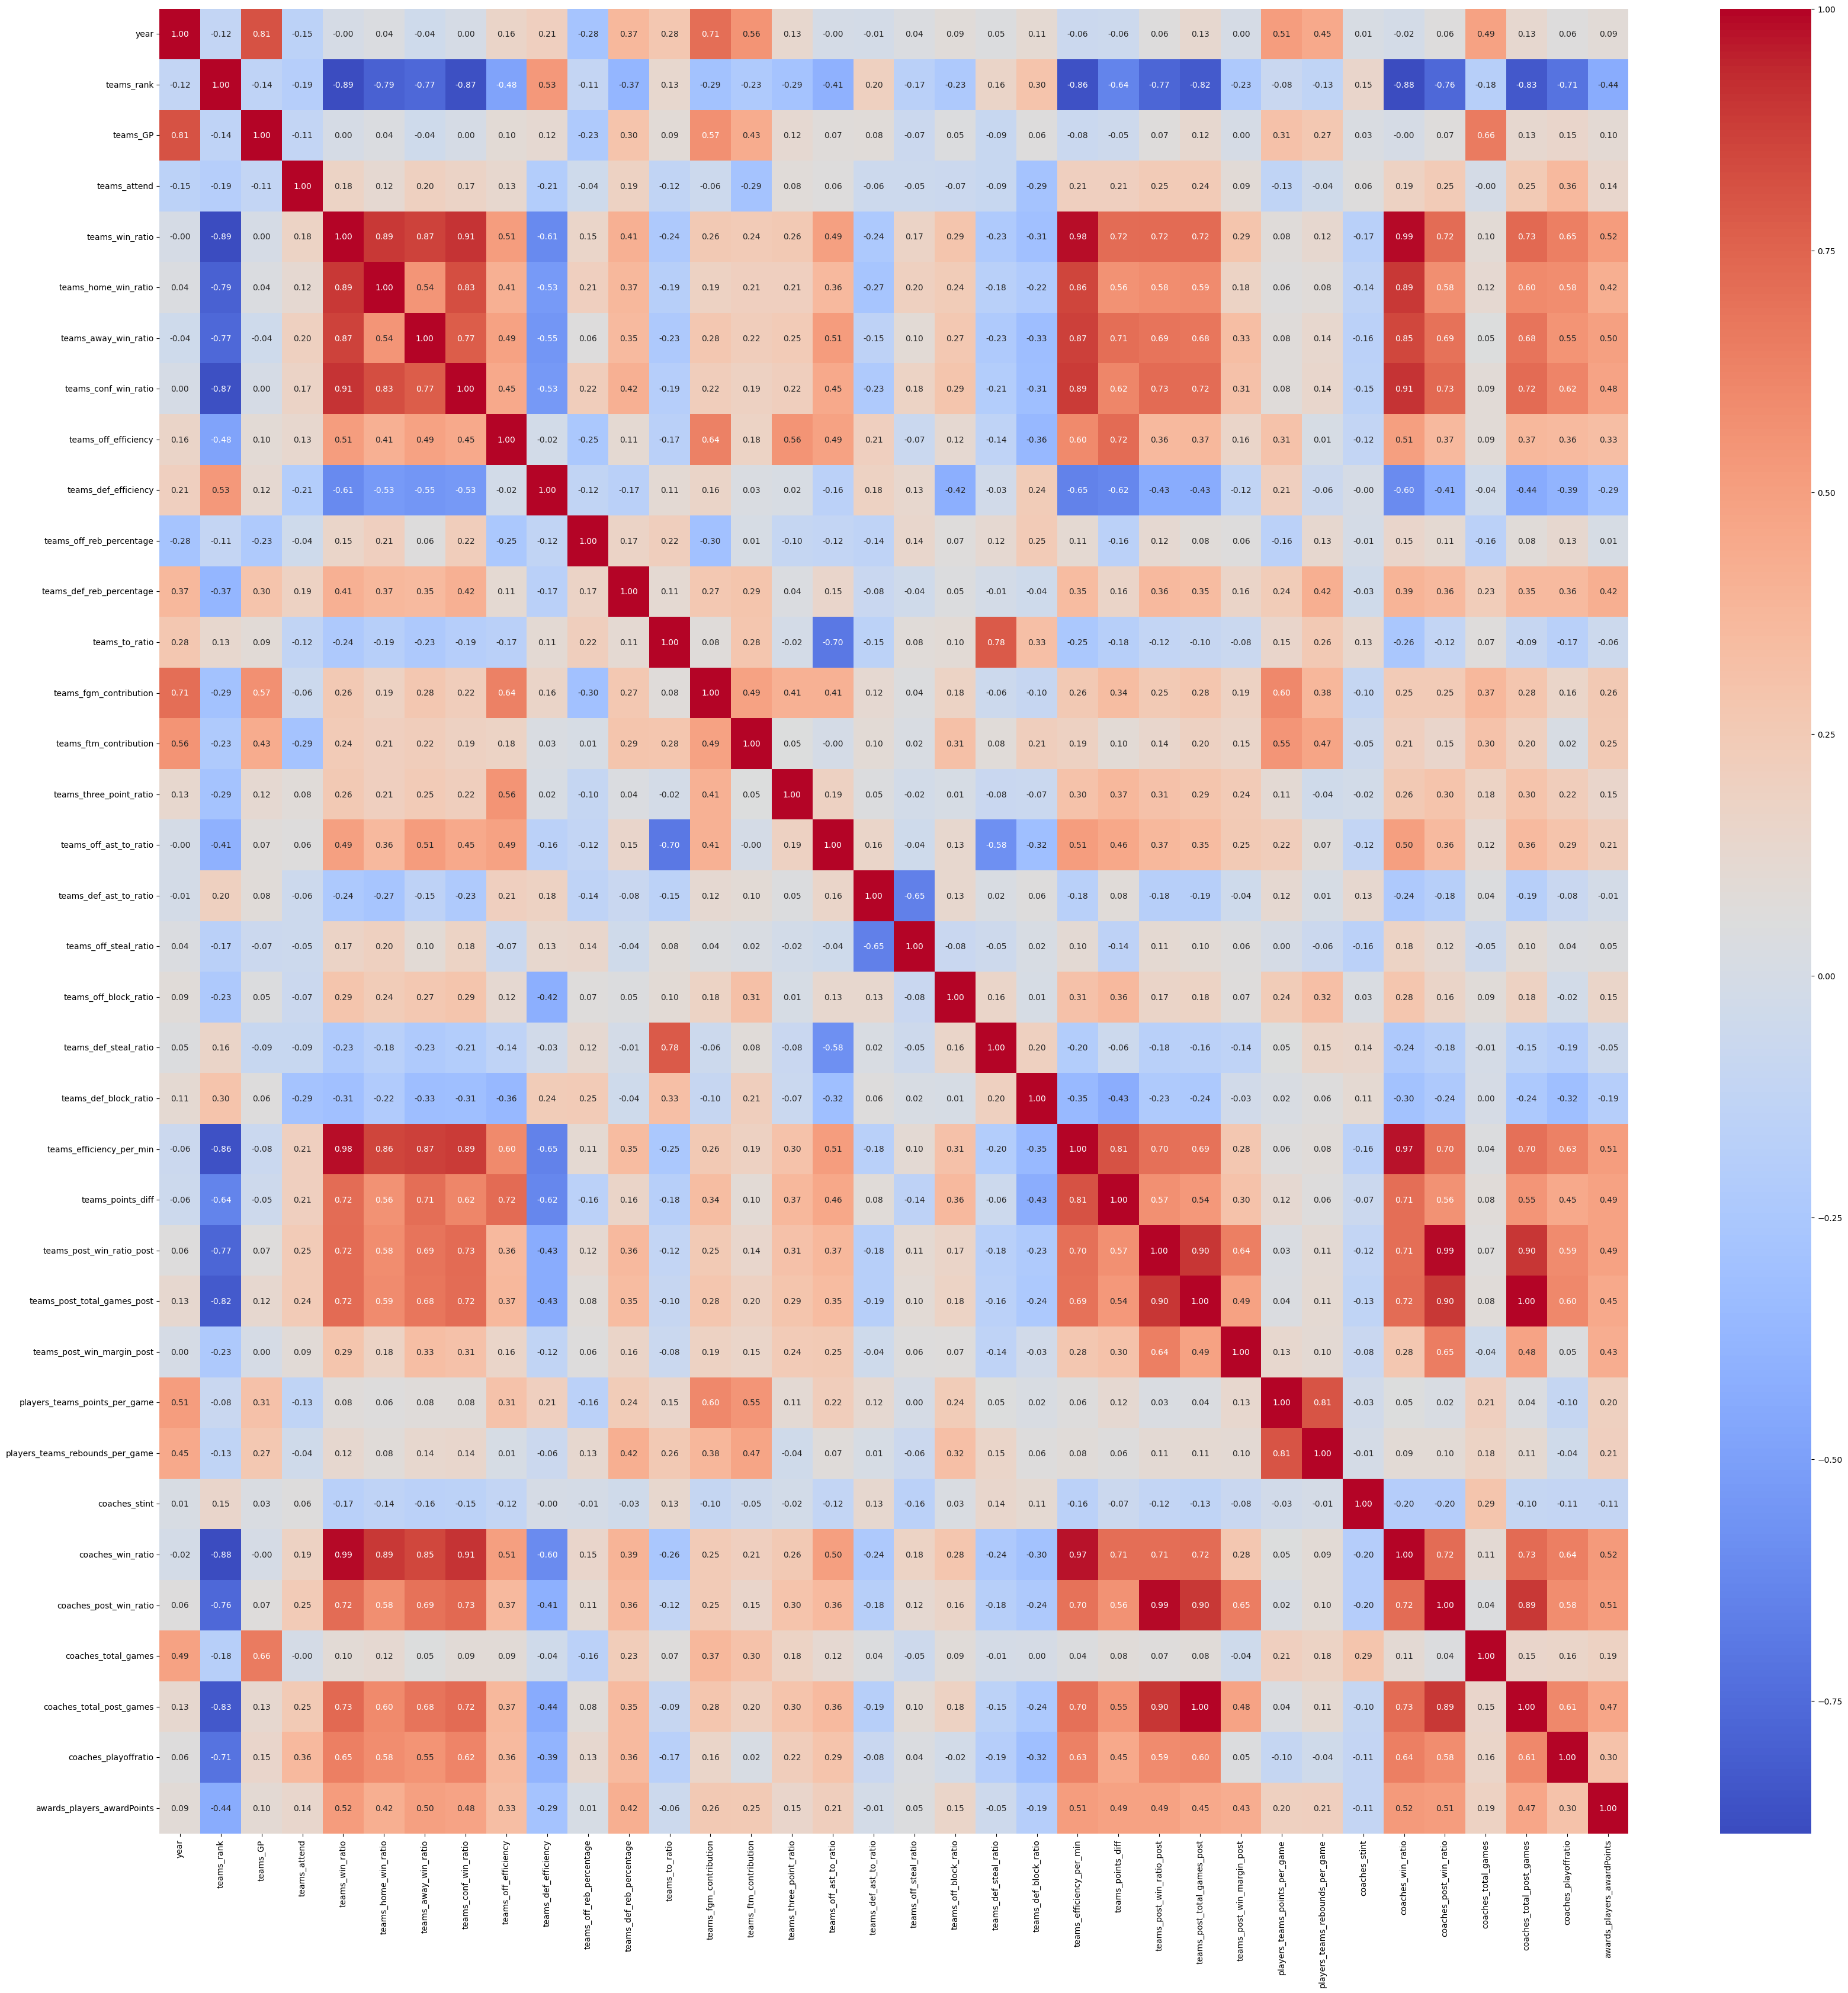

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = team_data_no_str.corr()

# Save the correlation matrix as a CSV file
corr_matrix.to_csv("correlation_matrix.csv")

# Plot heatmap for correlation
plt.figure(figsize=(40,40))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


In [21]:
# Find columns with high correlation (|correlation| >= 0.75) to determine which to drop
columns_to_drop = set()

# Iterate through the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= 0.85:
            # Drop the second column in the highly correlated pair
            col2 = corr_matrix.columns[j]
            columns_to_drop.add(col2)

# Create a reduced dataframe by dropping these columns
reduced_data = team_data.drop(columns=list(columns_to_drop))

# Generate new interaction terms for remaining columns
# Select numerical columns for interaction term creation
remaining_numerical_columns = reduced_data.select_dtypes(include=[np.number]).columns

print(columns_to_drop)


{'teams_away_win_ratio', 'coaches_win_ratio', 'teams_win_ratio', 'teams_conf_win_ratio', 'teams_efficiency_per_min', 'teams_post_total_games_post', 'coaches_post_win_ratio', 'coaches_total_post_games', 'teams_home_win_ratio'}


In [22]:
reduced_data.columns

Index(['year', 'tmID', 'teams_franchID', 'teams_confID', 'teams_rank',
       'teams_playoff', 'teams_GP', 'teams_attend', 'teams_off_efficiency',
       'teams_def_efficiency', 'teams_off_reb_percentage',
       'teams_def_reb_percentage', 'teams_to_ratio', 'teams_fgm_contribution',
       'teams_ftm_contribution', 'teams_three_point_ratio',
       'teams_off_ast_to_ratio', 'teams_def_ast_to_ratio',
       'teams_off_steal_ratio', 'teams_off_block_ratio',
       'teams_def_steal_ratio', 'teams_def_block_ratio', 'teams_points_diff',
       'teams_post_win_ratio_post', 'teams_post_win_margin_post',
       'players_teams_points_per_game', 'players_teams_rebounds_per_game',
       'coaches_stint', 'coaches_total_games', 'coaches_playoffratio',
       'awards_players_awardPoints'],
      dtype='object')

In [23]:
# Step 1: Sort the data by team ID and year
reduced_data_sorted = reduced_data.sort_values(by=['tmID', 'year'])

# Step 2: Shift the `teams_playoff_Y` column by -1 year within each team group
reduced_data_sorted['next_season_playoff'] = reduced_data_sorted.groupby('tmID')['teams_playoff'].shift(-1)

# Sort data by `year` and `tmID`
reduced_data_sorted['teams_playoff'] = reduced_data_sorted['teams_playoff'].str.strip().map({'Y': 1, 'N': 0}).fillna(0).astype(int)
reduced_data_sorted['next_season_playoff'] = reduced_data_sorted['next_season_playoff'].str.strip().map({'Y': 1, 'N': 0}).fillna(0).astype(int)
# Initialize an empty list to store predictions and corresponding years
all_predictions = []
all_actuals = []

# List of years in the dataset
years = reduced_data_sorted['year'].unique()

In [24]:
# First, remove rows where 'year' == 10 from the dataset
#filtered_data = reduced_data_sorted[reduced_data_sorted['year'] != 10] old version dont use it

# some teams didn't play every year for exemple UTA :

# Créer une liste pour stocker les index des lignes à supprimer
indexes_to_drop = []

# Obtenir la liste des équipes uniques
teams = reduced_data_sorted['tmID'].unique()

# Parcourir chaque équipe
for team in teams:
    # Obtenir les lignes de l'équipe
    team_data = reduced_data_sorted[reduced_data_sorted['tmID'] == team]

    # Trouver l'année maximale pour cette équipe
    max_year = team_data['year'].max()

    # Trouver l'index de la ligne correspondant à l'année maximale
    index_to_drop = team_data[team_data['year'] == max_year].index

    # Ajouter les index à la liste des index à supprimer
    indexes_to_drop.extend(index_to_drop)

# Supprimer les lignes correspondantes dans le DataFrame original
filtered_data = reduced_data_sorted.drop(indexes_to_drop).reset_index(drop=True)


# Réinitialiser l'index si nécessaire
filtered_data = filtered_data.reset_index(drop=True)

# Now, define X and y
X = filtered_data.drop(columns=['next_season_playoff', 'year', 'tmID', 'teams_confID', 'teams_franchID'])
y = filtered_data['next_season_playoff']


In [25]:
filtered_data

,year,tmID,teams_franchID,teams_confID,teams_rank,teams_playoff,teams_GP,teams_attend,teams_off_efficiency,teams_def_efficiency,teams_off_reb_percentage,teams_def_reb_percentage,teams_to_ratio,teams_fgm_contribution,teams_ftm_contribution,teams_three_point_ratio,teams_off_ast_to_ratio,teams_def_ast_to_ratio,teams_off_steal_ratio,teams_off_block_ratio,teams_def_steal_ratio,teams_def_block_ratio,teams_points_diff,teams_post_win_ratio_post,teams_post_win_margin_post,players_teams_points_per_game,players_teams_rebounds_per_game,coaches_stint,coaches_total_games,coaches_playoffratio,awards_players_awardPoints,next_season_playoff
0,9,ATL,ATL,EA,7,0,34,141379,0.849480,0.907629,0.282392,0.647627,17.441176,2396,542,0.337793,0.829680,1.219251,8.382353,4.176471,9.117647,3.941176,-0.232595,0.000000,0.0,90.280886,42.711812,0,34,0.000000,0.0,1
1,1,CHA,CHA,EA,8,0,32,90963,0.881452,0.917989,0.314757,0.658996,15.500000,2017,431,0.339378,1.110887,1.399061,6.937500,2.812500,8.093750,3.843750,-0.292302,0.000000,0.0,83.889925,34.508183,0,32,0.000000,0.0,1
2,2,CHA,CHA,EA,4,1,32,105525,0.890381,0.834302,0.352740,0.650051,14.812500,1951,410,0.357477,0.985232,0.991051,6.781250,3.562500,8.031250,3.875000,1.009421,0.500000,0.0,68.969460,34.470022,0,32,0.500000,0.0,1
3,3,CHA,CHA,EA,2,1,32,106670,0.913575,0.886902,0.327549,0.688819,12.750000,2173,490,0.400380,1.215686,1.153302,7.531250,3.281250,6.500000,3.218750,0.480113,0.000000,-2.0,74.023695,32.655009,0,32,0.666667,0.0,1
4,4,CHA,CHA,EA,2,1,34,120061,0.897208,0.854418,0.355140,0.619704,14.617647,2135,456,0.361702,1.004024,1.046908,8.205882,3.382353,7.764706,3.058824,0.770212,0.000000,-2.0,68.417572,30.361657,0,34,1.000000,0.0,0
5,5,CHA,CHA,EA,5,0,34,116383,0.896315,0.860659,0.289593,0.626016,14.088235,1988,436,0.361656,0.889353,1.180778,6.176471,3.941176,7.147059,3.352941,0.570502,0.000000,0.0,67.757470,28.977934,0,34,0.500000,0.0,0
6,6,CHA,CHA,EA,6,0,34,98054,0.825778,0.897732,0.311024,0.631743,15.735294,1856,447,0.345515,0.921495,0.928839,8.352941,3.323529,7.911765,4.294118,-0.431719,0.000000,0.0,82.492815,38.063475,3,34,0.166667,0.0,0
7,7,CHI,CHI,EA,7,0,34,57635,0.823989,0.932015,0.293344,0.642115,15.500000,2187,449,0.292910,0.965844,1.164486,8.147059,3.676471,7.705882,3.529412,-0.540133,0.000000,0.0,87.734777,40.317827,0,34,0.000000,0.0,0
8,8,CHI,CHI,EA,6,0,34,66557,0.841667,0.905026,0.311635,0.673557,15.000000,2408,489,0.341912,1.170588,1.031802,7.705882,3.294118,7.117647,4.058824,-0.887031,0.000000,0.0,99.055690,44.870765,0,34,0.000000,4.0,0
9,9,CHI,CHI,EA,5,0,34,62146,0.848901,0.878237,0.310165,0.677817,15.441176,2128,564,0.322581,1.043810,1.017241,7.911765,4.382353,7.500000,3.647059,-0.352025,0.000000,0.0,82.926471,38.513090,0,34,0.000000,0.0,0


In [26]:
# Assumindo que X e y já estão definidos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definição dos parâmetros para o GridSearch
param_grid = {
    "n_d": [8, 16, 32],
    "n_a": [8, 16, 32],
    "n_steps": [3, 5, 7],
    "gamma": [1.0, 1.3, 1.5],
    "n_independent": [1, 2, 3],
    "n_shared": [1, 2, 3],
    "lambda_sparse": [1e-3, 1e-4, 1e-5],
    "optimizer_params": [dict(lr=0.02), dict(lr=0.01), dict(lr=0.005)]
}

# Criação do modelo TabNet base
tabnet_model = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    mask_type="entmax",
    scheduler_params=dict(mode="min", patience=5, min_lr=1e-5, factor=0.9),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    verbose=0
)

# Configuração do GridSearchCV
grid_search = GridSearchCV(
    estimator=tabnet_model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)

# Execução do GridSearch
grid_search.fit(X_train_scaled, y_train)

# Melhores parâmetros e melhor score
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor acurácia:", grid_search.best_score_)

# Avaliação do melhor modelo no conjunto de teste
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia no conjunto de teste - TabNet: {accuracy * 100:.2f}%')
print("\nRelatório de Classificação para TabNet:")
print(classification_report(y_test, y_pred))

# Importância das características
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("\nImportância das Características:")
print(feature_importance_df.head(10))

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits
Melhores parâmetros: {'gamma': 1.3, 'lambda_sparse': 0.001, 'n_a': 16, 'n_d': 32, 'n_independent': 1, 'n_shared': 1, 'n_steps': 3, 'optimizer_params': {'lr': 0.02}}
Melhor acurácia: 0.6695075757575758
Acurácia no conjunto de teste - TabNet: 48.00%

Relatório de Classificação para TabNet:
              precision    recall  f1-score   support

           0       0.40      0.36      0.38        11
           1       0.53      0.57      0.55        14

    accuracy                           0.48        25
   macro avg       0.47      0.47      0.47        25
weighted avg       0.47      0.48      0.48        25


Importância das Características:
                          feature  importance
15          teams_off_block_ratio    0.110124
16          teams_def_steal_ratio    0.091467
23                  coaches_stint    0.084290
18              teams_points_diff    0.071694
14          teams_off_steal_ratio    0.053333
19      

c:\Users\Utilizador\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


In [51]:
# GridSearch for Adaboost

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier  # Pour la classification


import warnings

warnings.filterwarnings('ignore')

# For AdaBoost
X_train_ab, X_test_ab, y_train_ab, y_test_ab = train_test_split(X, y, test_size=0.2, random_state=306981)
scaler_ab = StandardScaler()
X_train_ab_scaled = scaler_ab.fit_transform(X_train_ab)
X_test_ab_scaled = scaler_ab.transform(X_test_ab)


param_grid = {
    'n_estimators': [30, 50, 70, 100],  # Valeurs réduites pour éviter le surajustement
    'learning_rate': [0.01, 0.1, 0.5, 1],  # Valeurs variées pour voir leur impact
    'estimator': [DecisionTreeClassifier(max_depth=1),  # Arbres simples
                       DecisionTreeClassifier(max_depth=2)]  # Essaye d'autres profondeurs
}

# Set GridSearchCV
grid_search = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')

# Training with GridSearchCV
grid_search.fit(X_train_ab_scaled, y_train_ab)

# Display best parameters and score
print("best params :", grid_search.best_params_)
print("best accuracy :", grid_search.best_score_)

# Predictions with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_ab_scaled)

# Accuracy on test dataset
accuracy = accuracy_score(y_test_ab, y_pred)
print(f'Accuracy on test data : {accuracy * 100:.2f}%')

best params : {'estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.5, 'n_estimators': 50}
best accuracy : 0.6826315789473684
Accuracy on test data : 44.00%


In [ ]:
# GridSearch for XGBoost
import warnings

warnings.filterwarnings('ignore')

# Perform a new train-test split for XGBoost
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=719819)

# Scale the data
scaler_xgb = StandardScaler()
X_train_xgb_scaled = scaler_xgb.fit_transform(X_train_xgb)
X_test_xgb_scaled = scaler_xgb.transform(X_test_xgb)

#hyperparameters
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Set GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, cv=5, scoring='accuracy')

# Training GridSearchCV
grid_search_xgb.fit(X_train_xgb_scaled, y_train_xgb)

# Best Parameters, Best accuracy
print("Best params XGBoost :", grid_search_xgb.best_params_)
print("Best accuracy XGBoost :", grid_search_xgb.best_score_)

# XGBoost predictions
best_model_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_model_xgb.predict(X_test_xgb_scaled)

# Accuracy
accuracy_xgb = accuracy_score(y_test_xgb, y_pred_xgb)
print(f'Accuracy on test data - XGBoost : {accuracy_xgb * 100:.2f}%')

In [ ]:
#GridSearch for SVM

warnings.filterwarnings('ignore')

# Perform a new train-test split for SVM
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.2,random_state=38022)

# Scale the data
scaler_svm = StandardScaler()
X_train_svm_scaled = scaler_svm.fit_transform(X_train_svm)
X_test_svm_scaled = scaler_svm.transform(X_test_svm)


from sklearn.svm import SVC

# hyperparameters
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],  # Essaye différents noyaux
    'gamma': ['scale', 'auto']  # Gestion de la complexité du modèle
}

# Set Gridsearch for svm
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')

# Training
grid_search_svm.fit(X_train_svm_scaled, y_train_svm)

# Best parameters,best accuracy
print("best params SVM :", grid_search_svm.best_params_)
print("best accuracy SVM :", grid_search_svm.best_score_)

# predictions with best model
best_model_svm = grid_search_svm.best_estimator_
y_pred_svm = best_model_svm.predict(X_test_svm_scaled)

# accuracy
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
print(f'Accuracy on test data -  SVM : {accuracy_svm * 100:.2f}%')


print(classification_report(y_test_svm, y_pred_svm))

In [ ]:
# GridSearch for Logistic Regression

# Perform a new train-test split for Logistic Regression
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.2,random_state=212627)

# Scale the data
scaler_lr = StandardScaler()
X_train_lr_scaled = scaler_lr.fit_transform(X_train_lr)
X_test_lr_scaled = scaler_lr.transform(X_test_lr)


# Logistic Regression
log_reg = LogisticRegression(solver='liblinear')

# Gridsearch parameters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Paramètre de régularisation
    'penalty': ['l1', 'l2']  # Types de pénalités
}

# Gridsearch
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_lr_scaled, y_train_lr)

# Predictions
y_pred = grid_search.predict(X_test_lr_scaled)

# Accuracy
accuracy = accuracy_score(y_test_lr, y_pred)
print(f'Accuracy on test data : {accuracy * 100:.2f}%')

print(classification_report(y_test_lr, y_pred))


In [ ]:
# GridSearch for Naive Bayes

# Perform a new train-test split for Naive Bayes
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X, y, test_size=0.2, random_state=48390)

# Naive Bayes may not require scaling, but if needed:
scaler_nb = StandardScaler()
X_train_nb_scaled = scaler_nb.fit_transform(X_train_nb)
X_test_nb_scaled = scaler_nb.transform(X_test_nb)


from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Create a pipeline
pipeline_nb = Pipeline([
    ('classifier', GaussianNB())
])

# Define a parameter grid
param_grid_nb = [
    {
        'classifier': [GaussianNB()],
        # GaussianNB doesn't have hyperparameters to tune
    },
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.5, 1.0, 1.5]  # Smoothing parameter
    },
    {
        'classifier': [BernoulliNB()],
        'classifier__alpha': [0.5, 1.0, 1.5],
        'classifier__binarize': [0.0, 0.5]  # Threshold for binarizing features
    }
]

# Create the GridSearchCV object
grid_search_nb = GridSearchCV(pipeline_nb, param_grid_nb, cv=5, scoring='accuracy')

# Training
grid_search_nb.fit(X_train_nb_scaled, y_train_nb)

# Best parameters and best accuracy
print("Best parameters Naive Bayes:", grid_search_nb.best_params_)
print("Best cross-validation accuracy Naive Bayes:", grid_search_nb.best_score_)

# Predictions with the best model
best_model_nb = grid_search_nb.best_estimator_
y_pred_nb = best_model_nb.predict(X_test_nb_scaled)

# Accuracy
accuracy_nb = accuracy_score(y_test_nb, y_pred_nb)
print(f'Accuracy on test data - Naive Bayes: {accuracy_nb * 100:.2f}%')

print(classification_report(y_test_nb, y_pred_nb))


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train_vc, X_test_vc, y_train_vc, y_test_vc = train_test_split(X, y, test_size=0.2, random_state=80923)
scaler_vc = StandardScaler()
X_train_vc_scaled = scaler_ab.fit_transform(X_train_vc)
X_test_vc_scaled = scaler_ab.transform(X_test_vc)

# Best estimators from your grid searches
best_estimator_adaboost = best_model  # AdaBoost
best_estimator_xgb = best_model_xgb   # XGBoost
best_estimator_svm = best_model_svm   # SVM
best_estimator_logreg = grid_search.best_estimator_  # Logistic Regression
best_estimator_nb = best_model_nb     # Naive Bayes

# List of estimators for the ensemble
estimators = [
    ('adaboost', best_estimator_adaboost),
    ('xgboost', best_estimator_xgb),
    ('svm', best_estimator_svm),
    ('logreg', best_estimator_logreg),
    ('naive_bayes', best_estimator_nb)
]

# Check if all classifiers support predict_proba
all_have_predict_proba = all(hasattr(clf, "predict_proba") for name, clf in estimators)

# Create the VotingClassifier
if all_have_predict_proba:
    voting = 'soft'
else:
    voting = 'hard'

voting_clf = VotingClassifier(estimators=estimators, voting=voting)



In [ ]:
# Fit the voting classifier on the scaled training data
voting_clf.fit(X_train_vc_scaled, y_train_vc)
warnings.filterwarnings('ignore')

In [ ]:
# Make predictions on the scaled test data
y_pred_voting = voting_clf.predict(X_test_vc_scaled)

# Evaluate the performance
accuracy_voting = accuracy_score(y_test_vc, y_pred_voting)
print(f'Accuracy on test data - Voting Classifier ({voting} voting): {accuracy_voting * 100:.2f}%')

print("Classification Report for Voting Classifier:")
print(classification_report(y_test_vc, y_pred_voting))
